In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import nengo_dl

c:\users\terry\py3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.datasets import fetch_openml
inputs, targets = fetch_openml('mnist_784', version=1, return_X_y=True)
inputs.shape = (-1, 28, 28)

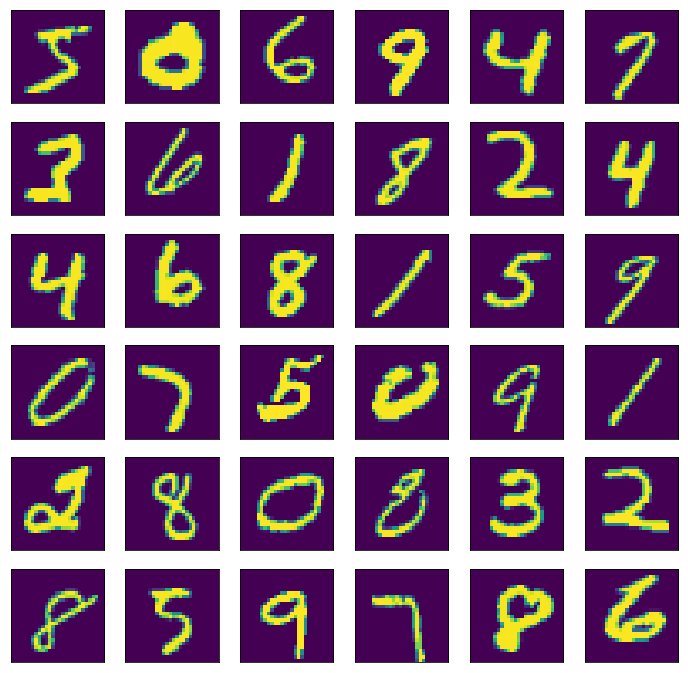

In [3]:
S = 6
plt.figure(figsize=(12,12))
indices = np.linspace(0, len(inputs)-1, S*S).astype(int)
for i in range(S*S):
    plt.subplot(S, S, i+1)
    plt.imshow(inputs[indices[i]])
    plt.xticks([])
    plt.yticks([])

In [6]:
D_input = inputs.shape[1] * inputs.shape[2]

def make_input_layer(source, source_shape,
               spatial_stride, spatial_size,
               n_features, n_parallel,
               kernel_stride, kernel_size):
    
    net = nengo.Network()
    max_rate = 100
    amp = 1 / max_rate
    net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None    
    
    i = 0
    w = spatial_size[0]
    h = spatial_size[1]
    items = np.arange(source_shape[0]*source_shape[1])
    items.shape = source_shape
    while i + w <= source_shape[0]:
        j = 0
        while j + h <= source_shape[1]:
            with net:
                
                sp = nengo.Node(None, size_in=w*h,
                                label='[%d:%d,%d:%d]' % (j,j+h,i,i+w))
                
                for k in range(n_parallel):
                    conv = nengo.Convolution(n_features, (1, w, h), channels_last=False, 
                                             kernel_size=kernel_size, strides=kernel_stride)
                    ens = nengo.Ensemble(conv.output_shape.size, dimensions=1,
                                         label='k%d' % k)
                    nengo.Connection(sp, ens.neurons, transform=conv)
                
            
            nengo.Connection(source[items[j:j+h][:,i:i+w]], sp, synapse=None)
            j += spatial_stride[1]
        i += spatial_stride[0]
        
    return None, None
                
            
        
    


model = nengo.Network()
with model:
    stim = nengo.Node(None, size_in=D_input)
    
    layer1, layer1_shape = make_input_layer(
                        stim, (inputs.shape[1], inputs.shape[2]),
                        spatial_stride=(7,7), spatial_size=(14,14),
                        n_features=6, n_parallel=2,
                        kernel_stride=(2,2), kernel_size=(3,3))
    

In [7]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

In [56]:
D_input = inputs.shape[1] * inputs.shape[2]


class ConvNet:
    def __init__(self, net, max_rate=100):
        amp = 1 / max_rate
        net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
        net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
        net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
        net.config[nengo.Connection].synapse = None    
        self.net = net
        self.layers = []
        self.output_shapes = []
        
    def make_input_layer(self, source_shape,
                   spatial_stride, spatial_size,
                   n_features, n_parallel,
                   kernel_stride, kernel_size):
        
        with self.net:
            self.input = nengo.Node(None, size_in=source_shape[0]*source_shape[1], label='input')

            i = 0
            w = spatial_size[0]
            h = spatial_size[1]
            items = np.arange(source_shape[0]*source_shape[1])
            items.shape = source_shape
            layer = []
            while i + w <= source_shape[0]:
                row = []
                j = 0
                while j + h <= source_shape[1]:
                    col = []

                    sp = nengo.Node(None, size_in=w*h,
                                    label='[%d:%d,%d:%d]' % (j,j+h,i,i+w))

                    for k in range(n_parallel):
                        conv = nengo.Convolution(n_features, (1, w, h), channels_last=False, 
                                                 kernel_size=kernel_size, strides=kernel_stride)
                        ens = nengo.Ensemble(conv.output_shape.size, dimensions=1,
                                             label='%s' % conv.output_shape)
                        nengo.Connection(sp, ens.neurons, transform=conv)
                        col.append(ens)
                    row.append(col)            

                    nengo.Connection(self.input[items[j:j+h][:,i:i+w]], sp, synapse=None)
                    j += spatial_stride[1]
                i += spatial_stride[0]
                layer.append(row)
            self.layers.append(layer)
            self.output_shapes.append(conv.output_shape)
            
    def make_middle_layer(self, n_features, n_parallel, n_local, n_remote, kernel_stride, kernel_size):
        with self.net:
            prev_layer = self.layers[-1]
            prev_output_shape = self.output_shapes[-1]
            layer = []
            for prev_row in prev_layer:
                row = []
                for prev_col in prev_row:
                    col = []
                    
                    index = 0
                    for k in range(n_parallel):
                        conv = nengo.Convolution(n_features, prev_output_shape, channels_last=False,
                                                 kernel_size=kernel_size, strides=kernel_stride)
                        ens = nengo.Ensemble(conv.output_shape.size, dimensions=1,
                                             label='%s' % conv.output_shape)
                        for kk in range(n_local):
                            prev_k = prev_col[index%len(prev_col)]
                            conv = nengo.Convolution(n_features, prev_output_shape, channels_last=False,
                                                     kernel_size=kernel_size, strides=kernel_stride)
                            nengo.Connection(prev_k.neurons, ens.neurons, transform=conv)
                            index += 1
                        col.append(ens)
                    row.append(col)
                layer.append(row)
            self.layers.append(layer)
            self.output_shapes.append(conv.output_shape)
            
    def make_output_layer(self, dimensions):
        with self.net:
            self.output = nengo.Node(None, dimensions, label='output')
            for row in self.layers[-1]:
                for col in row:
                    for k in col:
                        nengo.Connection(k.neurons, self.output, transform=nengo_dl.dists.Glorot())
            
    


model = nengo.Network()
with model:
    stim = nengo.Node(None, size_in=D_input)
    
    convnet = ConvNet(nengo.Network(label='convnet'))
    
    
    
    convnet.make_input_layer(
                        (inputs.shape[1], inputs.shape[2]),
                        spatial_stride=(7,7), spatial_size=(14,14),
                        n_features=6, n_parallel=2,
                        kernel_stride=(2,2), kernel_size=(3,3))
    nengo.Connection(stim, convnet.input)
    
    convnet.make_middle_layer(n_features=12, n_parallel=2,
                              n_local=2, n_remote=0,
                              kernel_stride=(1,1), kernel_size=(3,3))
    convnet.make_output_layer(10)
    

In [57]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)

In [70]:


class ConvNet:
    def __init__(self, net, max_rate=100):
        amp = 1 / max_rate
        net.config[nengo.Ensemble].neuron_type = nengo.RectifiedLinear(amplitude=amp)
        net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
        net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
        net.config[nengo.Connection].synapse = None    
        self.net = net
        self.layers = []
        self.output_shapes = []
        
    def make_input_layer(self, source_shape, spatial_stride, spatial_size):
        assert source_shape[0] == 1
        
        with self.net:
            self.input = nengo.Node(None, size_in=source_shape[1]*source_shape[2], label='input')

            i = 0
            w = spatial_size[0]
            h = spatial_size[1]
            items = np.arange(source_shape[1]*source_shape[2])
            items.shape = source_shape[1:]
            layer = []
            while i + w <= source_shape[1]:
                row = []
                j = 0
                while j + h <= source_shape[2]:
                    sp = nengo.Node(None, size_in=w*h,
                                    label='[%d:%d,%d:%d]' % (j,j+h,i,i+w))
                    row.append([sp])            

                    nengo.Connection(self.input[items[j:j+h][:,i:i+w]], sp)
                    j += spatial_stride[1]
                i += spatial_stride[0]
                layer.append(row)
            self.layers.append(layer)
            self.output_shapes.append((1,spatial_size[0], spatial_size[1]))
            
    def make_middle_layer(self, n_features, n_parallel, n_local, n_remote, kernel_stride, kernel_size):
        assert n_remote == 0
        with self.net:
            prev_layer = self.layers[-1]
            prev_output_shape = self.output_shapes[-1]
            layer = []
            for prev_row in prev_layer:
                row = []
                for prev_col in prev_row:
                    col = []
                    
                    index = 0
                    for k in range(n_parallel):
                        conv = nengo.Convolution(n_features, prev_output_shape, channels_last=False,
                                                 kernel_size=kernel_size, strides=kernel_stride)
                        ens = nengo.Ensemble(conv.output_shape.size, dimensions=1,
                                             label='%s' % conv.output_shape)
                        for kk in range(n_local):
                            prev_k = prev_col[index%len(prev_col)]
                            conv = nengo.Convolution(n_features, prev_output_shape, channels_last=False,
                                                     kernel_size=kernel_size, strides=kernel_stride)
                            nengo.Connection(prev_k, ens.neurons, transform=conv)
                            index += 1
                        col.append(ens.neurons)
                    row.append(col)
                layer.append(row)
            self.layers.append(layer)
            self.output_shapes.append(conv.output_shape)
            
    def make_output_layer(self, dimensions):
        with self.net:
            self.output = nengo.Node(None, dimensions, label='output')
            for row in self.layers[-1]:
                for col in row:
                    for k in col:
                        nengo.Connection(k, self.output, transform=nengo_dl.dists.Glorot())
            
    

model = nengo.Network()
with model:
    
    convnet = ConvNet(nengo.Network(label='convnet'))
    
    
    
    convnet.make_input_layer(
                        (1, inputs.shape[1], inputs.shape[2]),
                        spatial_stride=(7,7), spatial_size=(14,14))
    
    convnet.make_middle_layer(n_features=6, n_parallel=2, n_local=1, n_remote=0,
                        kernel_stride=(2,2), kernel_size=(3,3))
    convnet.make_middle_layer(n_features=12, n_parallel=2,
                              n_local=2, n_remote=0,
                              kernel_stride=(1,1), kernel_size=(3,3))
    convnet.make_output_layer(10)
    
    stim = nengo.Node(None, size_in=28*28)
    nengo.Connection(stim, convnet.input)
    

In [71]:
import nengo_gui.jupyter
nengo_gui.jupyter.InlineGUI(model)